In [1]:
import matplotlib.pyplot as plt
import IPython
import speech as sp
%matplotlib inline
%load_ext line_profiler

In [2]:
def frame_spectrum(x,sr):
    N = len(x)
    X = np.fft.rfft(x)
    a,g = sp.process.lpc_analysis(x,20)
    def lpc_spectra(omega):
        k = np.arange(20)
        return g/(1-a@np.exp(-1j*k*omega))
    vec_lpc_spectra = np.vectorize(lpc_spectra)
    omega = np.linspace(0,np.pi,(N//2)+1)
    freq = np.linspace(0,sr/2,(N//2)+1)
    fig, ax = plt.subplots(1,1)
    ax.plot(freq,20*np.log10(np.abs(X)/np.max(np.abs(X))))
    ax.plot(freq,20*np.log10(np.abs(vec_lpc_spectra(omega))))
    plt.plot()

In [3]:
def lpc_spectrum(a,omega):
    p = len(a)
    k = np.reshape(np.arange(p),(-1,1))
    return 1/(1-a@np.exp(-1j*k*omega))

In [4]:
def denoise_frame(x,p,noise_PSD,sr,iterations,plotting,y_clean):
    """Denoise a frame in the STFT domain by applying iterative Wiener filtering
    and approximating the PSD of the signal through the use of the all-pole model
    """
    dft_clean = np.fft.rfft(y_clean)
    dft = np.fft.rfft(x) #
    freq = np.linspace(0,sr/2,len(dft))
    omega = np.linspace(0,np.pi,len(dft))
    # First signal iterant is the original (noisy) signal
    s_i = x
    if(plotting):
        fig, axes = plt.subplots(nrows=iterations,ncols=2,figsize=(10,50))
    for it in range(iterations):
        a,_ = sp.process.lpc_analysis(s_i,p) # Compute the coefficients of the all-pole filter from the current iterant
        g2 = sp.process.squared_gain(a,noise_PSD,x)
        filtered_dft = sp.process.wiener_filtering(dft,sp.process.speech_PSD(a,g2,omega),noise_PSD)
        if(plotting):
            axes[it,1].plot(freq,20*np.log10(np.abs(filtered_dft/dft)),label='Wiener-Filter transfer function')
            axes[it,0].plot(freq,20*np.log10(np.abs(dft_clean)),label='Clean speech')
            axes[it,0].plot(freq,20*np.log10(np.abs(dft)), label = 'Noisy speech')
            #axes[it].plot(freq,20*np.log10(np.abs(lpc_spectrum(a,omega))),label='LPC spectrum')
            axes[it,0].plot(freq,20*np.log10(np.abs(filtered_dft)), label = 'Enhanced speech')
            axes[it,0].legend()
            axes[it,1].legend()
        
        s_i = np.fft.irfft(filtered_dft)

    return s_i


In [5]:
freq = np.linspace(0,10,10)
H = (freq < 5).astype(float)
H

NameError: name 'np' is not defined

In [2]:
import speech as sp
import numpy as np
# Parameters 

p = 20 #Order of the all pole filter
frame_size = 400 # Window size
iterations = 10 # Number of iterations of the Wiener Filter

# Preparing the sample
y_clean, sr = sp.data.load('../samples/speech_male/arctic_a0001.wav')
# For now : choose the SNR (Db) and add corresponding noise to the signal
SNR = 20
y = sp.data.add_noise_from_file(y_clean,sr,'../samples/noise/crowd.wav',SNR)

#y_filtered = lowpass_filter(y,sr,4800)
y_filtered = y
# Get the list of frames for the STFT filtering
list_frames,y_padded,w_a,w_s = sp.data.frame_split(y_filtered,frame_size)
n_frames = len(list_frames)

s = np.zeros(y_padded.shape)
y_clean_padded = np.concatenate((y_clean,np.zeros(len(y_padded)-len(y_clean))))
noise_PSD = np.var(y_padded[:frame_size])
for frame in range(n_frames):
    start,end = list_frames[frame]
    s[start:end] = s[start:end] + w_s*sp.process.denoise_frame(w_a*y_padded[start:end],p,noise_PSD,sr,iterations)

s = s/np.std(s)

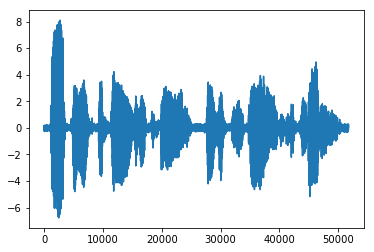

In [3]:
# Plot and play the noisy signal

plt.plot(y_filtered)
IPython.display.Audio(y_filtered,rate=sr)

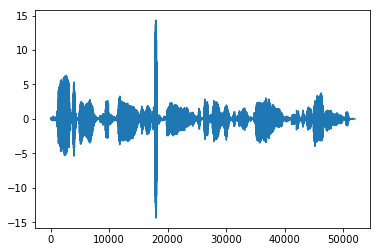

In [4]:
#Plot and play the denoised signal
plt.plot(s)
IPython.display.Audio(s,rate=sr)

In [40]:
def mse(speech,recovered_speech):
    recovered_speech = recovered_speech[:len(speech)]
    return np.mean((speech-recovered_speech)**2)

def frame_spectrum(x,sr):
    N = len(x)
    X = np.fft.rfft(x)
    a,g = sp.process.lpc_analysis(x,20)
    def lpc_spectra(omega):
        k = np.arange(20)
        return g/(1-a@np.exp(-1j*k*omega))
    vec_lpc_spectra = np.vectorize(lpc_spectra)
    omega = np.linspace(0,np.pi,(N//2)+1)
    freq = np.linspace(0,sr/2,(N//2)+1)
    fig, ax = plt.subplots(1,1)
    ax.plot(freq,20*np.log10(np.abs(X)/np.max(np.abs(X))))
    ax.plot(freq,20*np.log10(np.abs(vec_lpc_spectra(omega))))

0.46796467853
3.60336004916


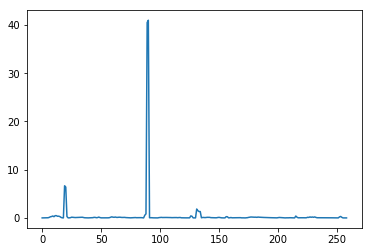

In [17]:
t_mse = sp.evaluate.time_mse(y_clean,s,200)
plt.plot(t_mse)
print(np.mean(t_mse))
print(np.std(t_mse))

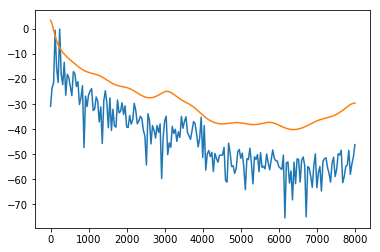

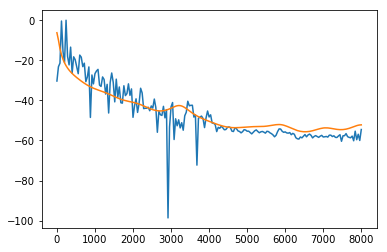

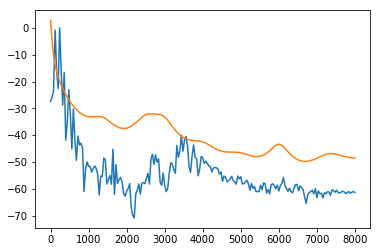

In [9]:
start, end = list_frames[50]
frame_spectrum(y[start:end],sr)
frame_spectrum(s[start:end],sr)
frame_spectrum(y_clean[start:end],sr)



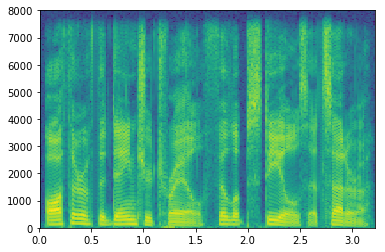

In [8]:
_,_,_, im_clean = plt.specgram(y_clean,NFFT = frame_size, Fs = sr)

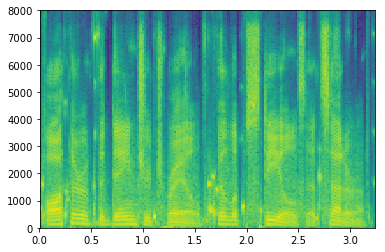

In [15]:
_,_,_, im_denoised = plt.specgram(s, NFFT = frame_size,Fs = sr)

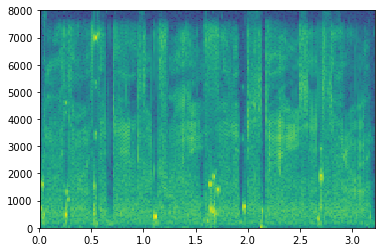

In [16]:
_,_,_, im_delta = plt.specgram(s[:len(y_clean)]-y_clean, NFFT = frame_size,Fs = sr,)


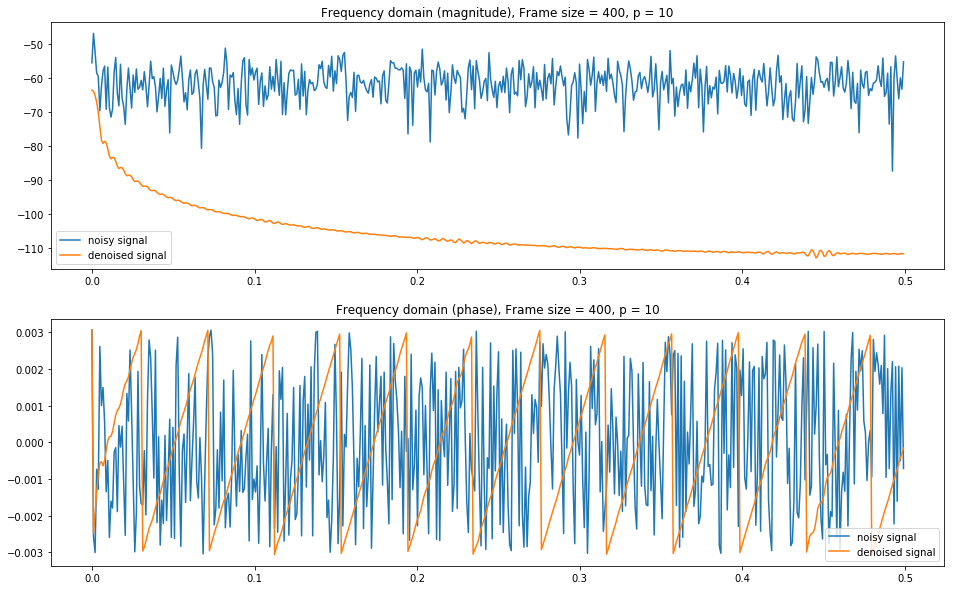

In [16]:
N = 1024
S = np.fft.fftshift(np.fft.fft(s, N))
Y = np.fft.fftshift(np.fft.fft(y, N))
freq = np.fft.fftshift(np.fft.fftfreq(N))
ind = [ind for ind, values in enumerate(freq) if values >= 0]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
# Plot spectrum (Magnitude)
axes[0].plot(freq[ind], 20*np.log10(np.abs(Y[ind])/N),label='noisy signal')
axes[0].plot(freq[ind], 20*np.log10(np.abs(S[ind])/N),label='denoised signal')
axes[0].legend()
axes[0].set_title('Frequency domain (magnitude), Frame size = {}, p = {}'.format(frame_size,p))

# Plot spectrum (Phase)
axes[1].plot(freq[ind], np.angle(Y[ind])/N,label='noisy signal')
axes[1].plot(freq[ind], np.angle(S[ind])/N,label='denoised signal')
axes[1].legend()
axes[1].set_title('Frequency domain (phase), Frame size = {}, p = {}'.format(frame_size,p))

plt.show()